In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import os.path
import re
import seaborn as sns
from matplotlib import cm as cm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.lda import LDA
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_recall_curve, average_precision_score
from time import time
import itertools
from sklearn.model_selection import validation_curve, learning_curve

%matplotlib inline

/opt/anaconda2/lib/python2.7/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [2]:
df = pd.read_csv('Data.raw/prescriber-info.csv')
print(df.shape)
df.head()
#path = '/Users/guillaumecollin/Dropbox/Cours AIC/Projet/Data/BioMed'
path2 = '/home/tp-home002/tfoltet/git/Opioids/'

(25000, 256)


In [3]:
opioids = pd.read_csv('Data.raw/opioids.csv')
print(opioids.shape)
opioids.head()

(113, 2)


,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


## 1. First some data visualisation

In [4]:
def correlation_matrix(df):

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax.grid(True)
    plt.title('Drug-related Features Correlation')
    labels= df.columns
    ax.set_xticklabels(labels,fontsize=7)
    ax.set_yticklabels(labels,fontsize=7)
    fig.colorbar(cax, ticks=[-1,-.9,-.8,-.7,-.6, -.5, -.4, -.3, -.2, -.1, 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')   

In [7]:
def OverdoseFatalities(overdoses):
    deathRatio = (overdoses.Deaths/overdoses.Population)*100
    temp = pd.DataFrame()
    temp['Abbrev'] = overdoses['Abbrev']
    temp['deathRatio'] = deathRatio
    temp = temp.sort_values('deathRatio')
    sns.barplot(temp.Abbrev, temp.deathRatio, color='g')
    plt.title('Opioid Overdose Fatalities Percentage per State')
    plt.xlabel('State')
    plt.xticks(rotation=80)
    plt.ylabel('Overdose Death Percentage')

In [8]:
#summary statistics of our dataset
stats = df.describe()
stats

,NPI,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
count,2.500000e+04,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,...,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,1.498162e+09,3.157160,2.370400,1.05368,7.041000,0.708440,8.962840,9.305720,16.12812,2.394840,...,2.18804,2.238160,2.551600,0.806240,19.198040,3.348240,4.070880,1.119440,11.573120,0.587520
std,2.877233e+08,20.755819,11.631601,6.66110,25.898648,5.224049,36.520987,29.375476,69.35317,14.266314,...,10.08554,13.325884,23.327117,4.951929,86.501125,17.127556,18.467437,10.299475,39.136616,0.492291
min,1.003002e+09,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.245473e+09,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.497842e+09,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.740406e+09,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.992999e+09,770.000000,644.000000,356.00000,1105.000000,275.000000,2431.000000,790.000000,5716.00000,596.000000,...,528.00000,902.000000,1814.000000,143.000000,6029.000000,596.000000,772.000000,694.000000,2107.000000,1.000000


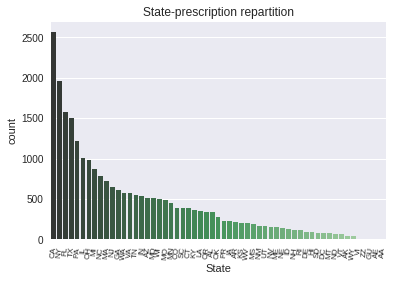

In [9]:
g = plt.figure()
sns.countplot(x="State", data= df, order = df['State'].value_counts().index,palette="Greens_d")
plt.xticks(rotation=85, fontsize = 8)
plt.title("State-prescription repartition")
plt.show()

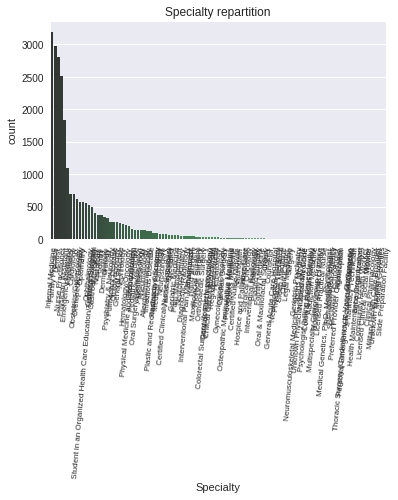

In [10]:
f = plt.figure()
sns.countplot(x="Specialty", data= df, order = df['Specialty'].value_counts().index,palette="Greens_d")
plt.xticks(rotation=85, fontsize = 8)
plt.title("Specialty repartition")
plt.show()

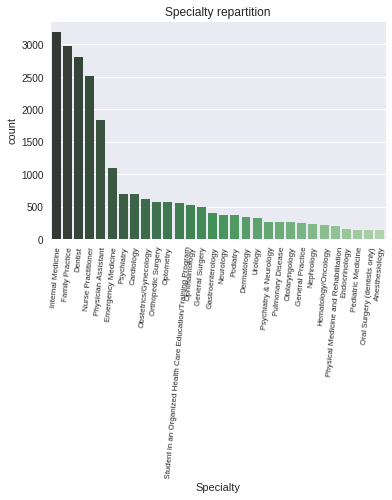

In [11]:
# Zooming on the biggest specialties
biggest_specialties = df.Specialty.value_counts().index[:30]
temp = df[df.Specialty.isin(biggest_specialties)]
f = plt.figure()
sns.countplot(x="Specialty", data= temp, order = temp['Specialty'].value_counts().index,palette="Greens_d")
plt.xticks(rotation=85, fontsize = 8)
plt.title("Specialty repartition")
plt.show()

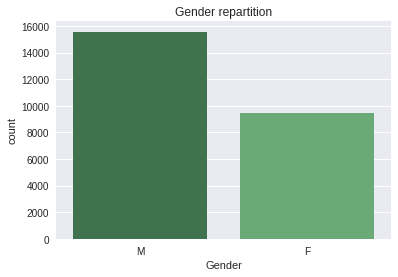

In [12]:
h =  plt.figure()
sns.countplot(x="Gender", data= df, order = df['Gender'].value_counts().index,palette="Greens_d")
plt.title('Gender repartition')
plt.show()

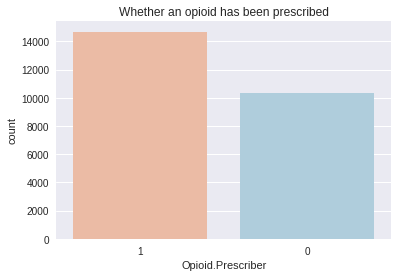

In [13]:
k = plt.figure()
sns.countplot(x = "Opioid.Prescriber", data= df, order = df['Opioid.Prescriber'].value_counts().index,palette="RdBu")
plt.title('Whether an opioid has been prescribed')
plt.show()

#### La modification suivante ne concerne que 10 lignes, est-ce bien utile?


df_copy = df.copy()
for lf in least_frequent:
    df_copy['State'].loc[df_copy['State']==lf] = 'other'

In [14]:
#replace the least frequent states by a new category "other"
freq_state = df['State'].value_counts()
least_frequent=list(freq_state[freq_state<10].index)
df_copy = df.copy()
for lf in least_frequent:
    df_copy['State'].loc[df_copy['State']==lf] = 'other'

/opt/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## 2. Some preprocessing

In [15]:
#replace hyphens and spaces with periods to match the dataset
opioids_names = list(re.sub(r'[-\s]','.',x) for x in opioids.values[:,0])
#determe how many/ what opioids are mentioned in the data
df_cols = list(df.columns)
common_drugs = [name for name in df_cols if name in opioids_names]
print("there are %d opioids cited among the drugs"%len(common_drugs))

there are 11 opioids cited among the drugs


In [16]:
#removing opioid prescriptions from the data, otherwise we'll be cheating!
df_cols_no_opioids = [col for col in df_cols if not col in opioids_names]
df_no_opioids = df_copy[df_cols_no_opioids].copy()

In [17]:
#factorizing categorical variables
uniques = dict()
Categorical=['Gender','State','Credentials','Specialty']
for col in Categorical:
    uniques[col] = df_no_opioids[col].unique()
    df_no_opioids[col] = pd.factorize(df_no_opioids[col])[0]

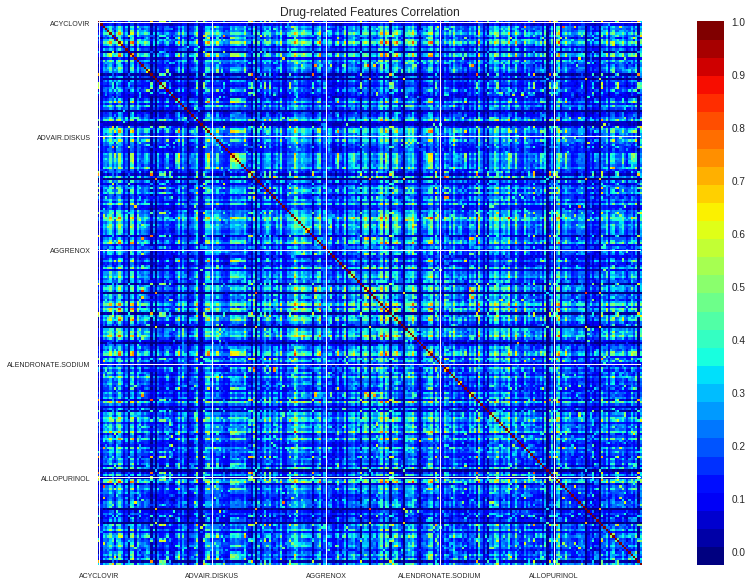

In [18]:
#studying correlation of drug-related features
corr = (df_no_opioids.iloc[:,5:244]).corr()
correlation_matrix(df_no_opioids.iloc[:,5:244])

## 3. Now let's create the cross val

In [19]:
#split our dataset into train/validation/test sets
X=np.array(df_no_opioids)[:,:244]
y = df_no_opioids['Opioid.Prescriber']
X_train, X_test, y_train, y_test = train_test_split(X,np.array(y), test_size = 0.2, random_state=42)


## 4. And finally some ML

In [23]:
#trying out some classification models
clf = RandomForestClassifier(n_estimators=150, criterion ='entropy',random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_acc_score = clf.score(X_test, y_test)
print('Our mean accuracy: %.3f' %mean_acc_score)

Our mean accuracy: 0.837


In [21]:
# Comparons avec l'accuracy attendue pour un classifieur aléatoire
distrib = df['Opioid.Prescriber'].value_counts()/df.shape[0]
acc = np.sum(distrib**2)
print('Pour comparaison: un classifieur aléatoire suivant la loi de distribution du label aurait une accuracy de: %.3f'%acc)

Pour comparaison: un classifieur aléatoire suivant la loi de distribution du label aurait une accuracy de: 0.515


## Comparison with other classifiers

In [47]:
""" AdaBoost Classifier """
from sklearn.ensemble import AdaBoostClassifier

ada_param_grid = {'n_estimators': [50, 100, 150, 300, 600],
                  'learning_rate': [0.1, 0.2, 0.5, 1., 1.5],
                 }

adaBoost = AdaBoostClassifier(random_state=88)
ada_grid_search = GridSearchCV(estimator=adaBoost, param_grid=ada_param_grid, cv=5, n_jobs=-1)
start = time()
ada_grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(ada_grid_search.grid_scores_)))
print(ada_grid_search.best_params_)
print('Best training score: %.3f' %ada_grid_search.best_score_)

GridSearchCV took 637.18 seconds for 25 candidate parameter settings.
{'n_estimators': 600, 'learning_rate': 0.5}
Best training score: 0.811


In [31]:
from sklearn.ensemble import AdaBoostClassifier
#ada_clf = ada_grid_search.best_estimator_
ada_clf = AdaBoostClassifier(n_estimators=600, learning_rate=0.5, random_state=88)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
y_probas_ada = [proba[1] for proba in ada_clf.predict_proba(X_test)]
acc_score = ada_clf.score(X_test, y_test)
print('Our mean accuracy: %.3f' %acc_score)
#AUC score
auc_score = roc_auc_score(y_test, y_probas_ada)
print("AUC score: %.2f" %auc_score)

Our mean accuracy: 0.819
AUC score: 0.90


In [24]:
""" Random Forest Classifier with Recursive Feature Selection """
from sklearn.feature_selection import RFE
selector = RFE(estimator=clf)
selector = selector.fit(X_train, y_train)

In [25]:
y_pred_rfe = selector.predict(X_test)
y_probas_rfe = [proba[1] for proba in selector.predict_proba(X_test)]
acc_score = selector.score(X_test, y_test)
print('Our mean accuracy: %.3f' %acc_score)
#AUC score
auc_score_rfe = roc_auc_score(y_test, y_probas_rfe)
print("AUC score: %.2f" %auc_score_rfe)

Our mean accuracy: 0.840
AUC score: 0.92


In [29]:
""" Gradient Boosting Classifier """

gbc_param_grid = {'n_estimators': [100, 300, 600],
                  'learning_rate': [0.1, 0.2, 0.5, 1.],
                 }

gbc = GradientBoostingClassifier(random_state=111)
gbc_clf = GridSearchCV(estimator=gbc, param_grid=gbc_param_grid, cv=5, n_jobs=-1)
start = time()
gbc_clf.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gbc_clf.grid_scores_)))
print(gbc_clf.best_params_)
print('Best training score: %.3f' %gbc_clf.best_score_)

GridSearchCV took 1017.61 seconds for 12 candidate parameter settings.
{'n_estimators': 600, 'learning_rate': 0.2}
Best training score: 0.833


In [30]:
gbc_clf = GradientBoostingClassifier(n_estimators=600, learning_rate=0.2, random_state=111)
gbc_clf.fit(X_train, y_train)
y_pred_gbc = gbc_clf.predict(X_test)
y_probas_gbc = [proba[1] for proba in gbc_clf.predict_proba(X_test)]
acc_score_gbc = gbc_clf.score(X_test, y_test)
print('Our mean accuracy: %.3f' %acc_score_gbc)
#AUC score
auc_score_gbc = roc_auc_score(y_test, y_probas_gbc)
print("AUC score: %.2f" %auc_score_gbc)

Our mean accuracy: 0.839
AUC score: 0.92


In [33]:
""" Gaussian Naive Bayes Classifier """

bayes_clf = GaussianNB()
bayes_clf.fit(X_train, y_train)

y_pred_bayes = bayes_clf.predict(X_test)
y_probas_bayes = [proba[1] for proba in bayes_clf.predict_proba(X_test)]
acc_score_bayes = bayes_clf.score(X_test, y_test)
print('Our mean accuracy: %.3f' %acc_score_bayes)
#AUC score
auc_score_bayes = roc_auc_score(y_test, y_probas_bayes)
print("AUC score: %.2f" %auc_score_bayes)

Our mean accuracy: 0.585
AUC score: 0.51


In [34]:
""" Linear Discriminant Analysis Classifier """

lda_clf = LDA()
lda_clf.fit(X_train, y_train)

y_pred_lda = lda_clf.predict(X_test)
y_probas_lda = [proba[1] for proba in lda_clf.predict_proba(X_test)]
acc_score_lda = lda_clf.score(X_test, y_test)
print('Our mean accuracy: %.3f' %acc_score_lda)
#AUC score
auc_score_lda = roc_auc_score(y_test, y_probas_lda)
print("AUC score: %.2f" %auc_score_lda)

Our mean accuracy: 0.710
AUC score: 0.81


In [ ]:
""" Support Vector Classifier with Principal Component Analysis """
# Stopped after 5 hours and 30 minutes of calculation
svc = SVC(random_state=99)

t0 = time()
pca = PCA().fit(X_train)
print("done in %0.3fs" %(time() - t0))

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

t0 = time()
param_grid = {'kernel': ['rbf'], 
              'gamma': [ 0.001, 0.01, 0.1, 1],
              'C': [10, 50, 100, 200, 500, 1000]}

svm_clf = GridSearchCV(svc, param_grid=param_grid, cv=5, n_jobs=-1)
svm_clf = svm_clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(svm_clf.best_estimator_)
print 'Best training score: %.3f' %svm_clf.best_score_

t0 = time()
y_pred = svm_clf.predict(X_test_pca)
svm_score = svm_clf.score(X_test_pca, y_test)
print("done in %0.3fs" % (time() - t0))
print('Our mean accuracy: %.3f' %svm_score)

done in 0.182s
done in 0.034s


In [46]:
""" Multi-Layer Perceptron Classifier """
nn_param_grid = { 
    'alpha': [0.0001, 0.001, 0.1, 1],
    'learning_rate_init': [0.001, 0.01, 0.1, 1],
    'solver': ['lbfgs', 'adam'],
    'activation': ['relu', 'tanh', 'logistic']
    }

nn = MLPClassifier(random_state=55)

nn_grid_search = GridSearchCV(estimator=nn, param_grid=nn_param_grid, cv=5, n_jobs=-1)
start = time()
nn_grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(nn_grid_search.grid_scores_)))
print(nn_grid_search.best_params_)
print('Best training score: %.3f' %nn_grid_search.best_score_)

nn = nn_grid_search.best_estimator_
nn.fit(X_train, y_train)
nn.predict(X_test)
acc_score = nn.score(X_test, y_test)
print('Our mean accuracy: %.3f' %acc_score)

GridSearchCV took 420.20 seconds for 96 candidate parameter settings.
{'alpha': 0.0001, 'activation': 'relu', 'learning_rate_init': 0.1, 'solver': 'adam'}
Best training score + 0.58815
Our mean accuracy: 0.585


In [ ]:
""" Multi-Layer Perceptron with Keras, we did not suceed to make it work """ 

from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, input_dim=244, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']

model.fit(X_train, y_train, epochs=20, batch_size=50)
score = model.evaluate(X_test, y_test, batch_size=50)

In [92]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
   
class_names = ["0","1"]


Confusion matrix, without normalization
[[1318  321]
 [ 335 2026]]


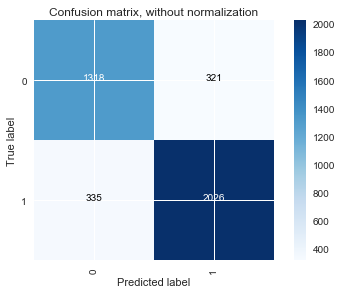

In [93]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    


Normalized confusion matrix
[[ 0.8   0.2 ]
 [ 0.14  0.86]]


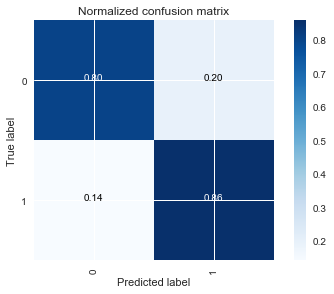

In [94]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
plt.show()

In [95]:
#compute AUC score
auc_score = roc_auc_score(y_test, y_pred)
print("AUC score: %.2f"%auc_score)

AUC score: 0.83


In [96]:
#compute balanced accuracy score
bal_accuracy1 =recall_score(y_test,y_pred, average='macro')
mean_acc_score = accuracy_score(y_test,y_pred)

fpr1, tpr1, thresholds1 = roc_curve(y_test, opt_clf.predict_proba(X_test)[:,1])

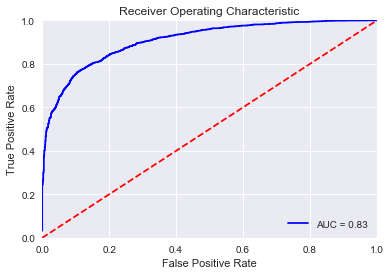

In [97]:
#PLOT ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

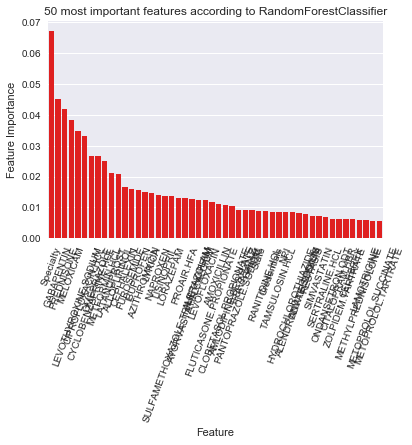

In [98]:
#analyzing feature importance
feature_import = opt_clf.feature_importances_
FI = pd.DataFrame()
FI['Feature']= list(df_no_opioids.columns)[:244]
FI['Importance'] = feature_import
FI.sort_values(by='Importance', ascending=False, inplace=True)
sns.barplot(FI['Feature'].iloc[:50], FI['Importance'].iloc[:50], color='r')
plt.title('50 most important features according to RandomForestClassifier')
plt.xlabel('Feature')
plt.xticks(rotation=70)
plt.ylabel('Feature Importance')
df_no_opioids.to_csv(os.path.join(path, "output", "preprocessed.csv"), sep=';')